In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme() 
from numpy.random import default_rng
rng = default_rng()

In [2]:
def monte_carlo(sample, proba = 0.95):
    mean = np.mean(sample)
    var = np.var(sample, ddof=1)
    alpha = 1 - proba 
    quantile = stats.norm.ppf(1 - alpha/2)  # fonction quantile 
    ci_size = quantile * np.sqrt(var / sample.size)
    result = { 'mean': mean, 'var': var, 
               'lower': mean - ci_size, 
               'upper': mean + ci_size }
    return result

# Pricing Black-Scholes, Call 1d

In [3]:
r = 0.1
sigma = 0.25
x0 = 100.
K = 100.
N, T = 10, 1

## Formule fermée du prix $P$ et du $\delta = \frac{\partial P}{\partial x}$

In [4]:
from scipy.stats import norm

def d1(spot, t, r=r, sigma=sigma, strike=K):
    return (np.log(spot / strike) + t * (r + 0.5*sigma**2)) / (sigma * np.sqrt(t))

def d2(spot, t, r=r, sigma=sigma, strike=K):
    return d1(spot, t, r, sigma, strike) - sigma * np.sqrt(t)

def price_call_BS(spot, t, r=r, sigma=sigma, strike=K):
    d1_ = d1(spot, t, r, sigma, strike)
    d2_ = d2(spot, t, r, sigma, strike)
    return spot * norm.cdf(d1_) - strike * np.exp(-r * t) * norm.cdf(d2_)

def dprice_call_BS(spot, t, r=r, sigma=sigma, strike=K):
    return norm.cdf(d1(spot, t, r, sigma, strike))

In [5]:
price_call_BS(x0, T, r, sigma, K)

14.9757907783113

In [6]:
dprice_call_BS(x0, T, r, sigma, K)

0.7002084045313042

## Couverture: ne rien faire

Pour la couverture on considère des dates $t_n = n \frac{T}{N}$, $n=0,\dots,N$ avec $N \in \{10, 100, 1000\}$. 

In [7]:
def simu_S(N, M): 
    h = T/N
    brown_acc = np.sqrt(h)*rng.standard_normal(size=(N, M))
    sample = np.zeros(shape=(N+1, M))
    sample[0] = x0
    for n in range(1, N+1):
        sample[n] = sample[n-1] * np.exp((r - 0.5 * sigma**2)*h + sigma*brown_acc[n-1])
    return sample

In [8]:
N, M = 10, int(1e6)
sample = simu_S(N, M)
sample_act = np.exp(-r * np.arange(N+1) * T/N)[:,None] * sample

In [9]:
monte_carlo(np.exp(-r*T)*np.maximum(sample[N]-K, 0))

{'mean': 14.960357202247884,
 'var': 396.29603911278036,
 'lower': 14.921339835408796,
 'upper': 14.999374569086973}

In [10]:
P0m = np.exp(-r*T)*np.maximum(sample[N]-K, 0).mean()
print("Prix Monte Carlo:", P0m)

Prix Monte Carlo: 14.96035720224789


In [11]:
P0e = price_call_BS(x0, T, r, sigma, K)
print("Prix exact:", P0e)

Prix exact: 14.9757907783113


In [12]:
value0 = P0e - np.exp(-r*T)*np.maximum(sample[N]-K, 0)
monte_carlo(value0)

{'mean': -0.018139495006634438,
 'var': 397.0454245087111,
 'lower': -0.05719373483018282,
 'upper': 0.020914744816913942}

In [13]:
(value0 > 0).mean()

0.631691

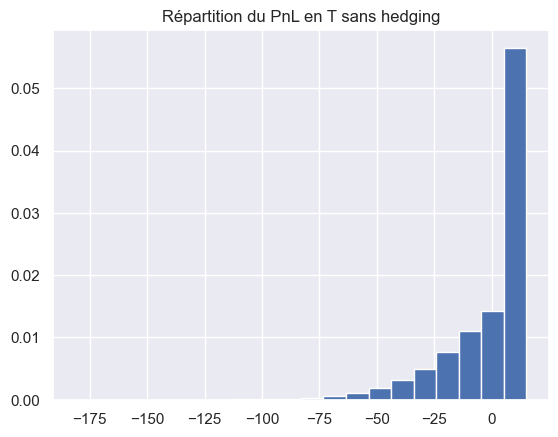

In [14]:
fig, ax = plt.subplots()
ax.hist(value0, bins=20, density=True)
ax.set_title("Répartition du PnL en T sans hedging")
plt.show()

## Couverture en delta: delta-hedging

In [15]:
delta = np.zeros_like(sample)
for n in range(N): 
    delta[n] = dprice_call_BS(sample[n], (N-n)*T/N)

In [16]:
value = np.zeros_like(sample)
value[0] = P0e - delta[0] * sample_act[0]   # on peut changer en P0m
for n in range(1,N):
    value[n] = value[n-1] - (delta[n] - delta[n-1]) * sample_act[n]
value[N] = value[N-1] + delta[N-1] * sample_act[N] - np.exp(-r*T)*np.maximum(sample[N]-K, 0)

In [17]:
monte_carlo(value[N])

{'mean': -0.0035035687997124827,
 'var': 5.410541662204369,
 'lower': -0.008062556954227477,
 'upper': 0.0010554193548025109}

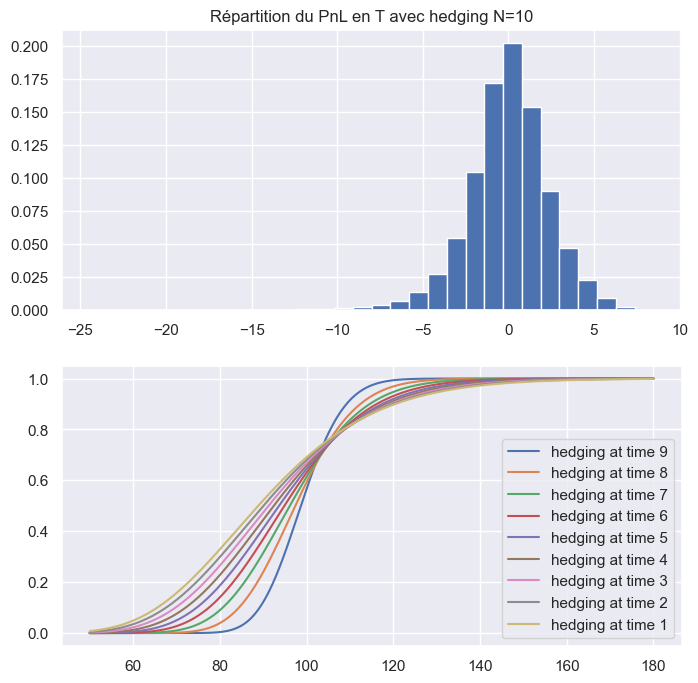

In [18]:
xx = np.linspace(50, 180, 1000)
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8,8))
ax1.hist(value[N], bins=30, density=True)
ax1.set_title(f"Répartition du PnL en T avec hedging N={N}")
for n in reversed(range(1, N)):
    ax2.plot(xx, dprice_call_BS(xx, (N-n)*T/N), label=f"hedging at time {n}")
ax2.legend()
plt.show()

In [19]:
(value[N] > 0).mean()

0.513607

l'opbjectif : Dans le cadre d'un call européen BS 1d et du notebook hedging, faire une couverture en moyenne quadratique optimale obtenue par réseaux de neurones: comparer les fonctions obtenues avec la fonction du delta (dérivée du prix par rapport au sous-jacent).